In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_and_preprocess_data(data_dir, img_size=(64, 64)):
    images = []
    labels = []

    # Loop through each folder (each letter) in the dataset directory
    for folder_name in os.listdir(data_dir):
        # Check if folder_name is a single character
        if len(folder_name) == 1:
            folder_path = os.path.join(data_dir, folder_name)
            if os.path.isdir(folder_path):
                # Label each letter with its index
                label = ord(folder_name) - ord('A')

                # Loop through each image in the folder
                for filename in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, filename)
                    # Read and resize the image
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)
                    # Convert image to grayscale
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    # Normalize pixel values to range [0, 1]
                    img = img / 255.0

                    images.append(img)
                    labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Define the path to the dataset directory
data_dir = "asl_alphabet_train/asl_alphabet_train"

# Load and preprocess the ASL Alphabet dataset
images, labels = load_and_preprocess_data(data_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (62400, 64, 64)
Shape of X_test: (15600, 64, 64)
Shape of y_train: (62400,)
Shape of y_test: (15600,)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [3]:
# Custom layer to resize images
class ResizeLayer(Layer):
    def call(self, inputs):
        return tf.image.resize(inputs, (64, 64))

# Function to define the Generator model
def build_generator(latent_dim):
    model_input = Input(shape=(latent_dim,))
    x = Dense(8 * 8 * 128)(model_input)
    x = Reshape((8, 8, 128))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="sigmoid")(x)
    x = ResizeLayer()(x)  # Use custom layer to resize images
    generator = Model(model_input, x, name="generator")
    return generator

# Function to define the Discriminator model
def build_discriminator(input_shape):
    model_input = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(model_input)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)
    discriminator = Model(model_input, x, name="discriminator")
    return discriminator


In [4]:
# Define the latent dimension for the Generator
latent_dim = 100

# Build and compile the Generator model
generator = build_generator(latent_dim)
generator.compile(optimizer="adam", loss="binary_crossentropy")

In [5]:
# Build and compile the Discriminator model
input_shape = (64, 64, 1)  # Input shape for the images
discriminator = build_discriminator(input_shape)
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summaries
generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 1)    │         1,025 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize_layer (ResizeLayer)      │ (None, 64, 64, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484,097 (5.66 MB)

 Trainable params: 1,484,097 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,881 (2.51 MB)

 Trainable params: 658,881 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Function to train the GAN
def train_gan(generator, discriminator, combined, X_train, latent_dim, epochs=100, batch_size=128):
    num_batches = len(X_train) // batch_size
    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            # Train Discriminator
            # Generate random noise
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            # Generate fake images
            generated_images = generator.predict(noise)
            # Select a random batch of real images
            real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
            
            # Ensure that real images have the correct shape
            real_images = np.expand_dims(real_images, axis=-1)  # Add channel dimension
            
            # Concatenate real and fake images
            X = np.concatenate([real_images, generated_images])
            # Create labels for real and fake images
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Label smoothing for real images
            
            # Train Discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            y_gen = np.ones(batch_size)
            # Train Generator
            discriminator.trainable = False
            g_loss = combined.train_on_batch(noise, y_gen)

            # Print progress
            print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx + 1}/{num_batches}, D_loss: {d_loss[0]}, G_loss: {g_loss}")


In [7]:
# Build the combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
combined = Model(gan_input, gan_output)
combined.compile(optimizer="adam", loss="binary_crossentropy")


In [20]:
# Specify the number of training samples to include
num_training_samples = 1500  # Adjust this number as needed

# Slice the training dataset to include only the specified number of samples
X_train_subset = X_train_truncated[:num_training_samples]

# Train the GAN with the subset of training data and the specified batch size
train_gan(generator, discriminator, combined, X_train_subset, latent_dim, epochs=5, batch_size=16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 1/5, Batch 1/93, D_loss: 0.35083335638046265, G_loss: [array(0.35083336, dtype=float32), array(0.35083336, dtype=float32), array(0.35083336, dtype=float32), array(0.45412433, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/5, Batch 2/93, D_loss: 0.350145161151886, G_loss: [array(0.35014516, dtype=float32), array(0.35014516, dtype=float32), array(0.35014516, dtype=float32), array(0.45434266, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/5, Batch 3/93, D_loss: 0.34952840209007263, G_loss: [array(0.3495284, dtype=float32), array(0.3495284, dtype=float32), array(0.3495284, dtype=float32), array(0.4545589, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/5, Batch 4/93, D_loss: 0.3490118384361267, G_loss: [array(0.34901184, dtype=float32), array(0.34901184, dtype=float32), array(0.34901184, dtype=float32), array(0.45477313, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/5, Batch 5/93, D_loss

In [35]:
# Define the directory where you want to save the weights
weights_dir = "saved_weights"
os.makedirs(weights_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the path where you want to save the weights
weights_path = os.path.join(weights_dir, "generator.weights.h5")

# Save the weights of the Generator model
generator.save_weights(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


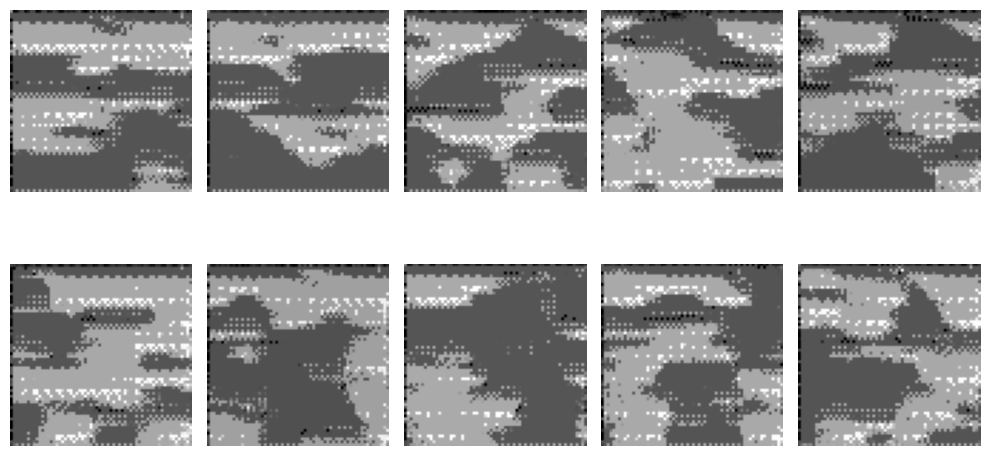

In [36]:
import matplotlib.pyplot as plt

# Function to generate images using the trained Generator
def generate_images(generator, latent_dim, num_images=10):
    # Generate random noise vectors
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    # Generate images using the Generator
    generated_images = generator.predict(noise)
    # Plot the generated images
    plt.figure(figsize=(10, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and plot images using the trained Generator
generate_images(generator, latent_dim, num_images=10)

In [37]:
def generate_images_for_word(generator, latent_dim, word):
    # Convert the word to uppercase
    word = word.upper()
    # Generate and display images for each letter in the word
    for letter in word:
        # Get the label for the letter
        label = ord(letter) - ord('A')
        # Generate random noise vector
        noise = np.random.normal(0, 1, (1, latent_dim))
        # Generate image using the Generator for the specified label
        generated_image = generator.predict(noise)[0, :, :, 0]
        # Plot the generated image
        plt.figure(figsize=(3, 3))
        plt.imshow(generated_image, cmap='gray')
        plt.title(f"Letter: {letter}")
        plt.axis('off')
        plt.show()

In [40]:
# User interface
def main():
    # Load the trained Generator model
    generator = build_generator(latent_dim)
    generator.load_weights('generator.weights.h5')  # Assuming you saved the weights
    
    # Input prompt
    word = input("Enter a word or letter: ")
    
    # Generate and display images for the input word or letter
    generate_images_for_word(generator, latent_dim, word)


Enter a word or letter:  hello


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


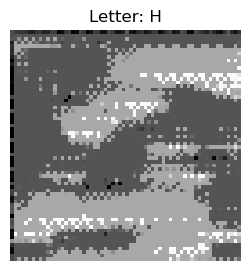

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


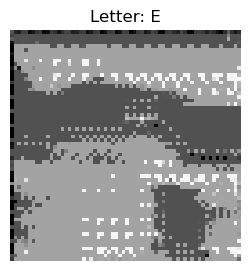

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


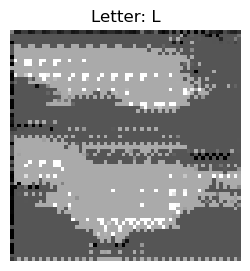

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


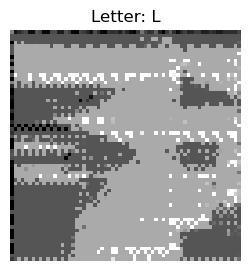

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


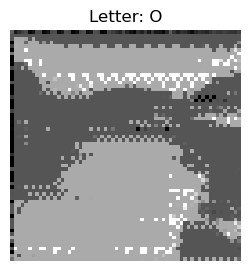

In [41]:
main()